<a href="https://colab.research.google.com/github/tuphr2234/RemoveSkyFromDataset/blob/main/Sky_Remover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download dataset

In [1]:
# Import the necessary packages
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
import json
import pathlib
from PIL import Image

In [2]:
# Set the path to the COCO dataset
!wget http://images.cocodataset.org/zips/val2017.zip
# Load the COCO annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-12-25 21:58:52--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.216.41, 52.216.59.161, 54.231.199.33, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.216.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  6.13MB/s    in 1m 59s  

2022-12-25 22:00:51 (6.54 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2022-12-25 22:00:52--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.213.177, 3.5.11.134, 52.217.166.145, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.213.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_train

In [3]:
!wget http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip

--2022-12-25 22:01:13--  http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.230.219, 52.216.56.97, 52.217.138.41, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.230.219|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 860725834 (821M) [application/zip]
Saving to: ‘panoptic_annotations_trainval2017.zip’

panoptic_annotation 100%[===================>] 820.85M  13.0MB/s    in 77s     

2022-12-25 22:02:31 (10.7 MB/s) - ‘panoptic_annotations_trainval2017.zip’ saved [860725834/860725834]



In [4]:
! mkdir images
! mkdir annotations

In [5]:
! unzip val2017.zip -d images
! unzip annotations_trainval2017.zip -d annotations


Streaming output truncated to the last 5000 lines.
 extracting: images/val2017/000000365745.jpg  
 extracting: images/val2017/000000320425.jpg  
 extracting: images/val2017/000000481404.jpg  
 extracting: images/val2017/000000314294.jpg  
 extracting: images/val2017/000000335328.jpg  
 extracting: images/val2017/000000513688.jpg  
 extracting: images/val2017/000000158548.jpg  
 extracting: images/val2017/000000132116.jpg  
 extracting: images/val2017/000000415238.jpg  
 extracting: images/val2017/000000321333.jpg  
 extracting: images/val2017/000000081738.jpg  
 extracting: images/val2017/000000577584.jpg  
 extracting: images/val2017/000000346905.jpg  
 extracting: images/val2017/000000433980.jpg  
 extracting: images/val2017/000000228144.jpg  
 extracting: images/val2017/000000041872.jpg  
 extracting: images/val2017/000000117492.jpg  
 extracting: images/val2017/000000368900.jpg  
 extracting: images/val2017/000000376900.jpg  
 extracting: images/val2017/000000352491.jpg  
 extracti

In [6]:
# create a different folder for each json annotation: captions, instances, person_keypoints

! mkdir annotations/annotations/captions
! mkdir annotations/annotations/instances
! mkdir annotations/annotations/person_keypoints

In [7]:
!mv /content/annotations/annotations/captions_val2017.json /content/annotations/annotations/captions/
!mv /content/annotations/annotations/instances_val2017.json /content/annotations/annotations/instances/
!mv /content/annotations/annotations/person_keypoints_val2017.json /content/annotations/annotations/person_keypoints/

In [8]:
instances_val2017_json = os.path.join('annotations/annotations/instances', "instances_val2017.json")
with open(instances_val2017_json) as f:
    imgs_instances_anns = json.load(f)

In [9]:
captions_val2017_json = os.path.join('annotations/annotations/captions', "captions_val2017.json")
with open(captions_val2017_json) as f:
    imgs_captions_anns = json.load(f)

In [10]:
person_keypoints_val2017_json = os.path.join('annotations/annotations/person_keypoints', "person_keypoints_val2017.json")
with open(person_keypoints_val2017_json) as f:
    imgs_person_keypoints_anns = json.load(f)

In [11]:
import pathlib
import matplotlib.image as mpimg

data_dir = pathlib.Path('/content/images/val2017')
images_str = os.listdir(data_dir)
#images = [cv2.imread(f"/content/images/val2017/{st}") for st in images_str]
#cv2_imshow(images[0][:,:])
image_dict = {st : cv2.imread(f"/content/images/val2017/{st}") for st in images_str}


In [12]:
imgs_instances_anns.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [13]:
# getting all json dictionaries to change them according to the removal of the sky
# in this case we will only use 'instances' for object detection and segmentation.
# splits to 5 lists of dictionaries:

annotations_instances = imgs_instances_anns['annotations']
images_annotiations_instances = imgs_instances_anns['images']


categories_instances = imgs_instances_anns['categories'] ###
info_instances = imgs_instances_anns['info']              ###  stays the same after removing the skies
licenses_instances = imgs_instances_anns['licenses']     ###


'''
annotations_captions = imgs_captions_anns['annotations']
images_annotiations_captions = imgs_captions_anns['images']
info_captions = imgs_captions_anns['info']
licenses_captions = imgs_captions_anns['licenses']

annotations_keypoints = imgs_person_keypoints_anns['annotations']
categories_keypoints = imgs_person_keypoints_anns['categories']
images_annotiations_keypoints = imgs_person_keypoints_anns['images']
info_keypoints = imgs_person_keypoints_anns['info']
licenses_keypoints = imgs_person_keypoints_anns['licenses']

'''

"\nannotations_captions = imgs_captions_anns['annotations']\nimages_annotiations_captions = imgs_captions_anns['images']\ninfo_captions = imgs_captions_anns['info']\nlicenses_captions = imgs_captions_anns['licenses']\n\nannotations_keypoints = imgs_person_keypoints_anns['annotations']\ncategories_keypoints = imgs_person_keypoints_anns['categories']\nimages_annotiations_keypoints = imgs_person_keypoints_anns['images']\ninfo_keypoints = imgs_person_keypoints_anns['info']\nlicenses_keypoints = imgs_person_keypoints_anns['licenses']\n\n"

In [14]:
print("annotations : ", annotations_instances[0].keys())
print("categories : ",categories_instances[0].keys())
print("images : ",images_annotiations_instances[0].keys())
print("info : ",info_instances.keys())
print("licenses : ",licenses_instances[0].keys())

annotations :  dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
categories :  dict_keys(['supercategory', 'id', 'name'])
images :  dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
info :  dict_keys(['description', 'url', 'version', 'year', 'contributor', 'date_created'])
licenses :  dict_keys(['url', 'id', 'name'])


#Downloads and imports for Detectron2

In [15]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 29.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=8cedf9ac05463e75b20de07039419b3dcb2a7f691f93181824b48a0954532ab4
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14718, done.
remote: Total 14718 (delta 0), reused 0 (delta 0), pack-reused 14718
Receiv

In [16]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [17]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#Load model

In [18]:
#@title Load model
skyDetector = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml" #@param {type:"string"}
ObjectDetector = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" #@param {type:"string"}


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(skyDetector))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(skyDetector)
predictor_sky = DefaultPredictor(cfg)


cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file(ObjectDetector))
cfg2.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(ObjectDetector)
predictor = DefaultPredictor(cfg2)


[12/25 22:03:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:16, 15.9MB/s]                           


[12/25 22:04:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:12, 14.7MB/s]                           


#Sky remover

In [19]:
'''
***
 removeSkyFromImage:
 
 im: the image
 predictor: the loaded model DefaultPredictor(cfg)
 class_id: the actual class id of the object we want to remove: if the object apears in every row in the picture, the whole picture will be deleted.
 40 is the default class_id of sky.

***
'''

def removeSkyFromImage(im,predictor = predictor_sky ,class_id=40):
  panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
  category_id = [i['category_id'] for i in segments_info]
  
  panoptic_seg_category = torch.zeros_like(panoptic_seg)

  for i in range(len(panoptic_seg)):
    for j in range(len(panoptic_seg[0])):
      panoptic_seg_category[i][j] = category_id[panoptic_seg[i][j]-1]

  for i in range(panoptic_seg_category.shape[0]):
    for j in range(panoptic_seg_category.shape[1]):
      if panoptic_seg_category[panoptic_seg_category.shape[0]-1- i][j] == class_id:
        return im[panoptic_seg_category.shape[0]-1-i:,:]
  return im  ## if there is no sky in the image


def showSegmentation(im,predictor = predictor, panoptic = False):
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  
  if panoptic:
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    outputs = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
  
  else:
    outputs = predictor(im)
    outputs = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  
  cv2_imshow(outputs.get_image()[:, :, ::-1])      
  return outputs

#Display image and skyless image

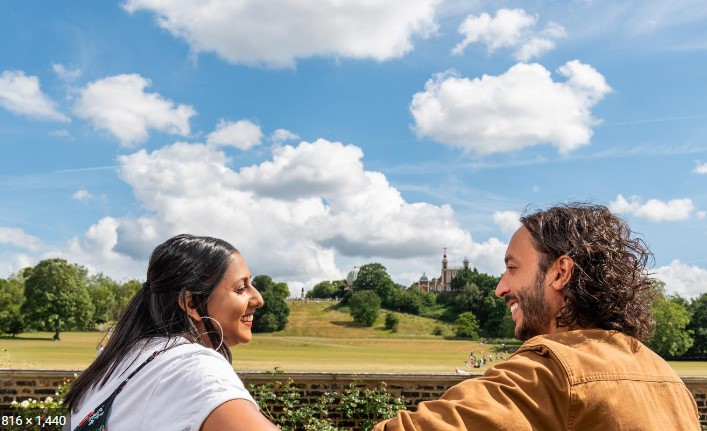

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


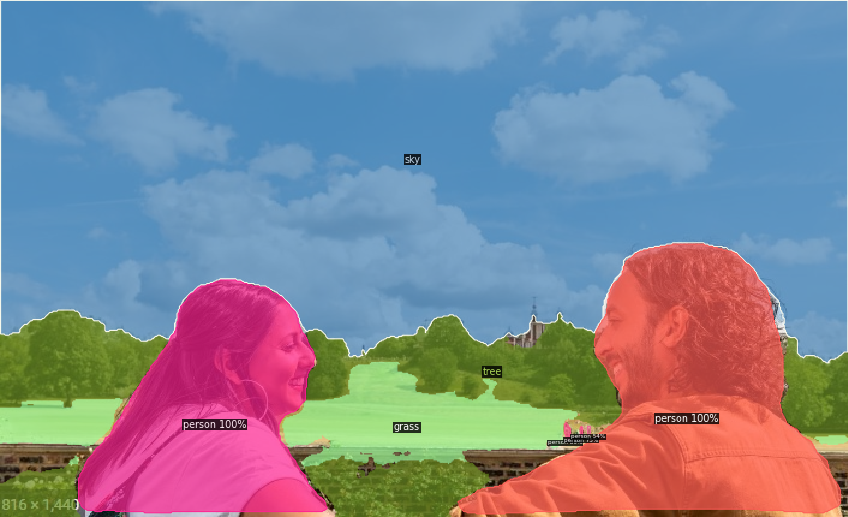

In [20]:
im = cv2.imread('/content/sky.jpg')
#im = images[1]
#im = image_dict['000000015660.jpg']
#im = image_dict['000000028285.jpg']
cv2_imshow(im)

output = showSegmentation(im,predictor = predictor_sky,panoptic=True)

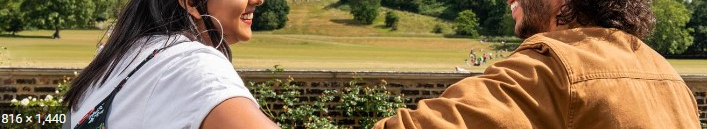

In [21]:
im2 = removeSkyFromImage(im,predictor_sky)
cv2_imshow(im2[:,:])

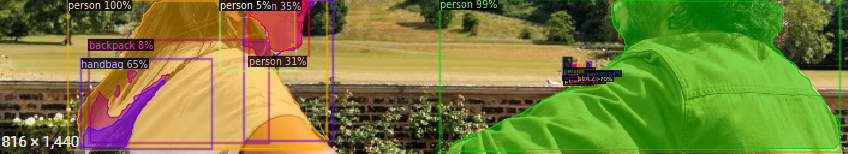

In [22]:
output = showSegmentation(im2,predictor)

#Prepare Dataset




In [23]:
'''
The object could be removed / partly removed / not removed at all

'''
def changeBbox(bbox,originalHeight,currentHeight): ## bbox annotation, image original height, image height after removeSkyFromImage

  if bbox[1]+bbox[3] < originalHeight -currentHeight:
    return True #### remove this annotation : the whole object was removed with the skies

  elif bbox[1] < originalHeight -currentHeight: ## The object was partly removed : the bbox y coordinate changes (x,y,w,h)
    bbox[1] = originalHeight -currentHeight

  return False # dont remove annotation

def changeSegmentation(segmentation,originalHeight,currentHeight):

  for i in range(0,len(segmentation),2):
    if segmentation[i+1] < originalHeight -currentHeight:
      segmentation[i+1] = originalHeight -currentHeight     ## if segmentation is above the line of removal: change y coordinate to the line itself








In [24]:
### Running through image annotations list (5000 in total for COCO val2017) and changing its height according to removeSkyFromImage and then changing the annotation list (36781 in total for COCO val2017)

def prepareDataset(annotations,images_str,images_dict,predictor = predictor_sky):

    images_annotation = annotations['images']   
    ann_annotations = annotations['annotations']

    for i,im_ann in enumerate(images_annotation):  ## images :  dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id']) -> list of dictionaries
      
      print("cropping ","Image ",im_ann['file_name'],"...")    

      images_dict[im_ann['file_name']] = removeSkyFromImage(images_dict[im_ann['file_name']],predictor,class_id=40) ## changing the image itself
      height = images_dict[im_ann['file_name']].shape[1]
      originalHeight = images_annotation[i]['height'] 
      images_annotation[i]['height'] = height   ## changing height annotation

      for j,ann in enumerate(ann_annotations):  ### changing bbox and segmentation after cutting the image : 
        notRemoved = True
        if im_ann['id'] == ann['image_id']:
          try:
            if changeBbox(ann_annotations[j]['bbox'],originalHeight,height):
              ann_annotations.remove(ann)
              notRemoved = False
          except KeyError:
            print("has no bbox")    
          if notRemoved:
            try:  
              changeSegmentation(ann_annotations[j]['segmentation'][0],originalHeight,height)
            except KeyError:
              print("has no segmentation")
      print("Image ",im_ann['file_name'], "was cropped and saved")    
          




#Initiate and save all changes

In [ ]:
instances_val2017_json = os.path.join('annotations/annotations/instances', "instances_val2017.json") ## reload if needed
with open(instances_val2017_json) as f:
    imgs_instances_anns = json.load(f)

prepareDataset(imgs_instances_anns,images_str,image_dict,predictor = predictor_sky)


### Save all changes : 


json_data = json.dumps(imgs_instances_anns)

with open('/content/annotations/annotations/instances_train2017_new.json', 'w') as f:
    json.dump(json_data, f)

directory ='/content/images_new'

if not os.path.exists(directory):
    os.makedirs(directory)

for im_name in images_str:
  image = Image.fromarray(image_dict[im_name])
  image.save(os.path.join(directory, f'{im_name}.jpg'))


cropping  Image  000000397133.jpg ...
Image  000000397133.jpg was cropped and saved
cropping  Image  000000037777.jpg ...
Image  000000037777.jpg was cropped and saved
cropping  Image  000000252219.jpg ...
Image  000000252219.jpg was cropped and saved
cropping  Image  000000087038.jpg ...
has no segmentation
Image  000000087038.jpg was cropped and saved
cropping  Image  000000174482.jpg ...
Image  000000174482.jpg was cropped and saved
cropping  Image  000000403385.jpg ...
Image  000000403385.jpg was cropped and saved
cropping  Image  000000006818.jpg ...
Image  000000006818.jpg was cropped and saved
cropping  Image  000000480985.jpg ...
Image  000000480985.jpg was cropped and saved
cropping  Image  000000458054.jpg ...


#Creating a DataCatalog for traning

In [ ]:
'''
instances:

annotations :  dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id']) -> list of dictionaries
categories :  dict_keys(['supercategory', 'id', 'name']) -> list of dictionaries
images :  dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id']) -> list of dictionaries
info :  dict_keys(['description', 'url', 'version', 'year', 'contributor', 'date_created']) -> a dictionary 
licenses :  dict_keys(['url', 'id', 'name']) -> list of dictionaries

'''

captions = "/content/annotations/annotations/captions"
instances = "/content/annotations/annotations/instances" ## imgs_instances_anns
person_keypoints = "/content/annotations/annotations/person_keypoints"

def get_my_dataset_dicts(annotation_dir_path=instances): # for all 3 different annotations of COCO's, choose 'instances' for object detection purpose.

    # Read the image file names and annotations from a folder
    image_dir = "/content/images/val2017"
    image_files = os.listdir(image_dir)
    dataset_dicts = []
    
    with open(annotation_dir_path, "r") as f:
            annotations = json.load(f)

    annotations['images']        

    for file_name in image_files:
        # Load the image and annotations
        image_path = os.path.join(image_dir, file_name)

        
        # Create a dictionary for the image and annotations
        record = {
            "file_name": image_path,
        #    "image_id": image_id,
            "annotations": annotations
        }
        dataset_dicts.append(record)
    return dataset_dicts

# Register the dataset with the DatasetCatalog
DatasetCatalog.clear()
DatasetCatalog.register("my_dataset", get_my_dataset_dicts)


In [ ]:
# Load the dataset dictionaries
dataset_dicts = DatasetCatalog.get("my_dataset")
